processing 0
Step=0, L=0.80, U=1.20, AngleBetweenColorAxes=22.717 deg, Color_g=(0.80,1.20), Shape_g=(0.80,1.20)
processing 1
Step=1, L=0.82, U=1.18, AngleBetweenColorAxes=20.531 deg, Color_g=(0.82,1.18), Shape_g=(0.82,1.18)
processing 2
Step=2, L=0.84, U=1.16, AngleBetweenColorAxes=18.299 deg, Color_g=(0.84,1.16), Shape_g=(0.84,1.16)
processing 3
Step=3, L=0.86, U=1.14, AngleBetweenColorAxes=16.066 deg, Color_g=(0.86,1.14), Shape_g=(0.86,1.14)
processing 4
Step=4, L=0.88, U=1.12, AngleBetweenColorAxes=13.818 deg, Color_g=(0.88,1.12), Shape_g=(0.88,1.12)
processing 5
Step=5, L=0.90, U=1.10, AngleBetweenColorAxes=11.519 deg, Color_g=(0.90,1.10), Shape_g=(0.90,1.10)
processing 6
Step=6, L=0.92, U=1.08, AngleBetweenColorAxes=9.280 deg, Color_g=(0.92,1.08), Shape_g=(0.92,1.08)
processing 7
Step=7, L=0.94, U=1.06, AngleBetweenColorAxes=6.962 deg, Color_g=(0.94,1.06), Shape_g=(0.94,1.06)
processing 8
Step=8, L=0.96, U=1.04, AngleBetweenColorAxes=4.650 deg, Color_g=(0.96,1.04), Shape_g=(0.96,1

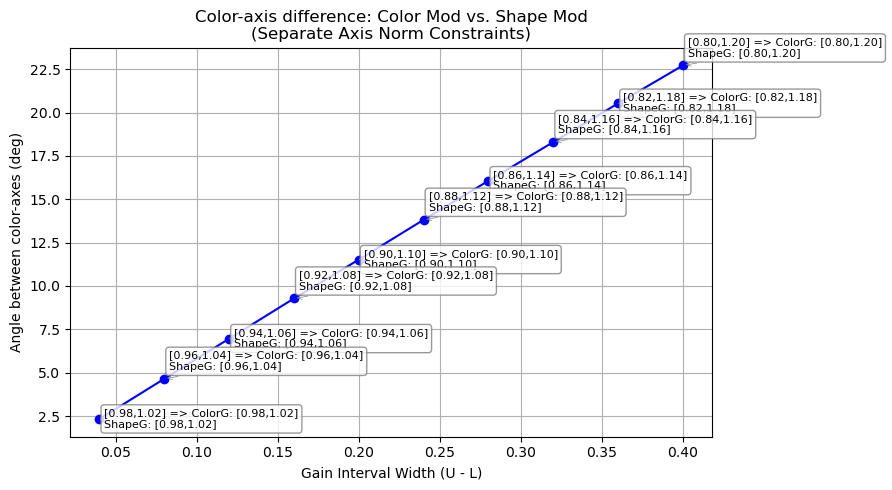

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.optimize import minimize, Bounds

np.random.seed(15)
N = 100
K = 2  # shape=0, color=1
desired_radius = 0.9
p_high = 0.2
p_low = 0.2

# -------------------------------------------------
# 1) Initialization
# -------------------------------------------------
def initialize_selectivity_matrix(N, K):
    """
    Half are shape-based, half are color-based, with a random distribution.
    """
    S = np.zeros((N, K))
    S[:N//2, 0] = np.random.rand(N//2)
    S[:N//2, 1] = 0.5 - S[:N//2, 0] / 2
    neg_idx = (S[:N//2, 0] - S[:N//2, 1]) < 0
    S[:N//2, 0][neg_idx] = np.random.uniform(0, 0.5, size=np.sum(neg_idx))
    S[N//2:, 1] = S[:N//2, 0]
    S[N//2:, 0] = S[:N//2, 1]
    return S

def initialize_W_F(S):
    """
    W_F divides each neuron's (shape,color) by its sum.
    """
    W_F = np.zeros_like(S)
    for i in range(S.shape[0]):
        r = np.sum(S[i])
        if r > 0:
            W_F[i] = S[i] / r
        else:
            W_F[i] = S[i]
    return W_F

def initialize_W_R(N, p_high, p_low, S, WR_tuned=False, desired_radius=0.9):
    """
    Build a recurrent matrix with four blocks and scale it.
    """
    W_R = np.zeros((N, N))
    halfN = N // 2

    ss_mask = np.random.rand(halfN, halfN) < p_high
    W_R[:halfN, :halfN][ss_mask] = np.random.rand(np.sum(ss_mask)) * 0.1

    sc_mask = np.random.rand(halfN, N - halfN) < p_low
    W_R[:halfN, halfN:][sc_mask] = np.random.rand(np.sum(sc_mask)) * 0.1

    cs_mask = np.random.rand(N - halfN, halfN) < p_low
    W_R[halfN:, :halfN][cs_mask] = np.random.rand(np.sum(cs_mask)) * 0.1

    cc_mask = np.random.rand(N - halfN, N - halfN) < p_high
    W_R[halfN:, halfN:][cc_mask] = np.random.rand(np.sum(cc_mask)) * 0.1

    np.fill_diagonal(W_R, 0)

    if WR_tuned:
        thresh = 0.2
        for i in range(N):
            for j in range(N):
                if i != j:
                    d = np.linalg.norm(S[i] - S[j])
                    if d < thresh:
                        W_R[i, j] *= (2 - d / thresh)

    # Rescale W_R so spectral radius = desired_radius
    eivals = np.linalg.eigvals(W_R)
    max_ev = np.max(np.abs(eivals))
    if max_ev > 0:
        W_R *= (desired_radius / max_ev)
    return W_R

# -------------------------------------------------
# 2) Response Computations
# -------------------------------------------------
def compute_response(W_R, W_F, shape_val, color_val, g_vector=None):
    """
    Returns steady-state response for a single (shape_val, color_val).
    """
    I = np.eye(W_R.shape[0])
    if g_vector is None:
        inv_mat = np.linalg.inv(I - W_R)
        WF_eff = W_F
    else:
        G = np.diag(g_vector)
        inv_mat = np.linalg.inv(I - G @ W_R)
        WF_eff = G @ W_F

    F = np.array([shape_val, color_val])
    return inv_mat @ (WF_eff @ F)

def compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=None):
    """
    Returns a [num_shape * num_color, N] array of responses
    by scanning over shape_vals x color_vals.
    """
    responses = []
    for s in shape_vals:
        for c in color_vals:
            resp = compute_response(W_R, W_F, s, c, g_vector)
            responses.append(resp)
    return np.array(responses)

# Define color axis for shape=0.3
def color_axis_direction(W_R, W_F, g, shape_fixed=0.3):
    """
    For a given g-vector, define color-axis as:
       r(shape=shape_fixed, color=1) - r(shape=shape_fixed, color=0).
    """
    resp_c0 = compute_response(W_R, W_F, shape_fixed, 0.0, g)
    resp_c1 = compute_response(W_R, W_F, shape_fixed, 1.0, g)
    return resp_c1 - resp_c0

# Define shape axis for color=0.3
def shape_axis_direction(W_R, W_F, g, color_fixed=0.3):
    """
    For a given g-vector, define shape-axis as:
       r(shape=1, color=color_fixed) - r(shape=0, color=color_fixed).
    """
    resp_s0 = compute_response(W_R, W_F, 0.0, color_fixed, g)
    resp_s1 = compute_response(W_R, W_F, 1.0, color_fixed, g)
    return resp_s1 - resp_s0

# -------------------------------------------------
# 3) Alignment Objectives
# -------------------------------------------------
def make_alignment_objective(axis_fn, pc_vector):
    """
    axis_fn: function(g) -> vector in R^N (the axis to align with pc_vector).
    pc_vector: the principal component we want to align with.

    We want to maximize cos^2(axis_fn(g), pc_vector).
    => minimize the negative.
    """
    def objective(g):
        d = axis_fn(g)
        denom = np.linalg.norm(d) * np.linalg.norm(pc_vector)
        if denom < 1e-15:
            return 0.0  # degenerate => no angle
        cos_val = np.dot(d, pc_vector) / denom
        cos_val = np.clip(cos_val, -1.0, 1.0)
        return -(cos_val**2)  # we want to maximize cos^2
    return objective

def angle_between_vectors(u, v):
    """
    Return the angle in degrees between vectors u and v,
    in [0..90] if we treat direction flips as identical.
    """
    denom = np.linalg.norm(u) * np.linalg.norm(v)
    if denom < 1e-15:
        return np.nan
    val = np.dot(u, v) / denom
    val = np.clip(val, -1, 1)
    angle_deg = np.degrees(np.arccos(val))
    return min(angle_deg, 180.0 - angle_deg)

# -------------------------------------------------
# MAIN
# -------------------------------------------------
if __name__ == "__main__":
    # 1) Create the network
    S = initialize_selectivity_matrix(N, K)
    W_F = initialize_W_F(S)
    W_R = initialize_W_R(N, p_high, p_low, S, WR_tuned=False, desired_radius=desired_radius)

    # 2) PCA on the unmodulated grid (11x11)
    grid_points = 11
    shape_vals = np.linspace(0, 1, grid_points)
    color_vals = np.linspace(0, 1, grid_points)

    responses_grid_unmod = compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=None)
    pca_grid = PCA(n_components=3)
    pca_grid.fit(responses_grid_unmod)

    # --- Changed from PC1 to PC2 here ---
    v2 = pca_grid.components_[1]    # Use the second principal component
    v2 /= np.linalg.norm(v2)        # normalize PC2

    init_g = np.ones(N)

    # -------------------------------------------------
    #   2.1) Reference Norms for Each Axis
    # -------------------------------------------------
    # Unmodulated color-axis at shape=0.3
    d_unmod_color = color_axis_direction(W_R, W_F, init_g, shape_fixed=0.3)
    norm_unmod_color_sq = np.linalg.norm(d_unmod_color)**2

    # Unmodulated shape-axis at color=0.3
    d_unmod_shape = shape_axis_direction(W_R, W_F, init_g, color_fixed=0.3)
    norm_unmod_shape_sq = np.linalg.norm(d_unmod_shape)**2

    # Constraints
    def color_axis_length_constraint(g):
        """ Keep color-axis norm same as unmodulated color-axis. """
        d = color_axis_direction(W_R, W_F, g, shape_fixed=0.3)
        return np.linalg.norm(d)**2 - norm_unmod_color_sq

    def shape_axis_length_constraint(g):
        """ Keep shape-axis norm same as unmodulated shape-axis. """
        d = shape_axis_direction(W_R, W_F, g, color_fixed=0.3)
        return np.linalg.norm(d)**2 - norm_unmod_shape_sq

    # Pre-construct objective functions
    color_obj = make_alignment_objective(
        axis_fn=lambda g: color_axis_direction(W_R, W_F, g, shape_fixed=0.3),
        pc_vector=v2  # align with PC2
    )
    shape_obj = make_alignment_objective(
        axis_fn=lambda g: shape_axis_direction(W_R, W_F, g, color_fixed=0.3),
        pc_vector=v2  # align with PC2
    )

    # We'll do a sweep over [L, U], changing L and U each iteration
    num_steps = 10
    step_val = 0.02

    all_interval_widths = []
    angle_differences = []
    all_annotations = []

    all_color_axis_colorMod = []
    all_color_axis_shapeMod = []
    all_color_angle_colorMod = []
    all_color_angle_shapeMod = []

    for i in range(num_steps):
        print("processing", i)
        # define the box bounds
        L = 0.8 + i * step_val
        U = 1.2 - i * step_val
        bounds = Bounds([L]*N, [U]*N)

        # --- 3.1) Color Modulation ---
        # Here we enforce the color-axis length constraint
        constraint_color = {
            'type': 'eq',
            'fun': color_axis_length_constraint
        }
        res_color = minimize(
            fun=color_obj,
            x0=init_g,
            method='SLSQP',
            bounds=bounds,
            constraints=[constraint_color],
            options={'maxiter': 200, 'disp': False}
        )
        g_opt_color = res_color.x
        cmin, cmax = np.min(g_opt_color), np.max(g_opt_color)

        # --- 3.2) Shape Modulation ---
        # Here we enforce the SHAPE-axis length constraint
        constraint_shape = {
            'type': 'eq',
            'fun': shape_axis_length_constraint
        }
        res_shape = minimize(
            fun=shape_obj,
            x0=init_g,
            method='SLSQP',
            bounds=bounds,
            constraints=[constraint_shape],
            options={'maxiter': 200, 'disp': False}
        )
        g_opt_shape = res_shape.x
        smin, smax = np.min(g_opt_shape), np.max(g_opt_shape)

        # --- 3.3) measure color-axis in each final network
        color_axis_colorMod = color_axis_direction(W_R, W_F, g_opt_color, 0.3)
        color_axis_shapeMod = color_axis_direction(W_R, W_F, g_opt_shape, 0.3)

        # angles
        color_angle_colorMod = angle_between_vectors(color_axis_colorMod, v2)
        color_angle_shapeMod = angle_between_vectors(color_axis_shapeMod, v2)
        angle_rotated = angle_between_vectors(color_axis_colorMod, color_axis_shapeMod)

        # store data
        actual_width = U - L
        all_interval_widths.append(actual_width)
        angle_differences.append(angle_rotated)
        all_color_axis_colorMod.append(color_axis_colorMod)
        all_color_axis_shapeMod.append(color_axis_shapeMod)
        all_color_angle_colorMod.append(color_angle_colorMod)
        all_color_angle_shapeMod.append(color_angle_shapeMod)

        # build multi-line annotation
        note_str = (
            f"[{L:.2f},{U:.2f}] => ColorG: [{cmin:.2f},{cmax:.2f}]\n"
            f"ShapeG: [{smin:.2f},{smax:.2f}]"
        )
        all_annotations.append(note_str)

        print(f"Step={i}, L={L:.2f}, U={U:.2f}, "
              f"AngleBetweenColorAxes={angle_rotated:.3f} deg, "
              f"Color_g=({cmin:.2f},{cmax:.2f}), Shape_g=({smin:.2f},{smax:.2f})")

    # ---------------------------------------------------------
    # Plot: angle difference vs. interval width
    # ---------------------------------------------------------
    plt.figure(figsize=(9,5))
    x_values = np.array(all_interval_widths)
    plt.plot(x_values, angle_differences, marker='o', color='b')

    for i, (x, y, txt) in enumerate(zip(x_values, angle_differences, all_annotations)):
        dx = 0.003
        dy = 0.5 if (i % 2 == 0) else -0.5
        plt.annotate(
            txt,
            xy=(x, y),
            xytext=(x + dx, y + dy),
            textcoords="data",
            arrowprops=dict(arrowstyle="->", lw=0.5, color="gray"),
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )

    plt.xlabel("Gain Interval Width (U - L)")
    plt.ylabel("Angle between color-axes (deg)")
    plt.title("Color-axis difference: Color Mod vs. Shape Mod\n(Separate Axis Norm Constraints)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [2]:
# ---------------------------------------------------------
# SAVE ALL DATA TO A SINGLE COMPRESSED FILE
# ---------------------------------------------------------
import os

out_filename = "hard_simulation_data_pc2.npz"

# Save everything you want. You can add or remove items as needed.
np.savez_compressed(
    out_filename,
    S=S,                                # Selectivity matrix (N x K)
    W_F=W_F,                            # Feedforward weights (N x K)
    W_R=W_R,                            # Recurrent weight matrix (N x N)
    responses_grid_unmod=responses_grid_unmod,  # grid responses without modulation
    v2=v2,                              # The first principal component vector
    all_interval_widths=np.array(all_interval_widths),
    angle_differences=np.array(angle_differences),
    all_annotations=np.array(all_annotations, dtype=object),
    all_color_axis_colorMod=np.array(all_color_axis_colorMod),
    all_color_axis_shapeMod=np.array(all_color_axis_shapeMod),
    all_color_angle_colorMod=np.array(all_color_angle_colorMod),
    all_color_angle_shapeMod=np.array(all_color_angle_shapeMod),
)

print(f"Data saved to '{out_filename}' (size: {os.path.getsize(out_filename)/1e3:.1f} KB)")


Data saved to 'hard_simulation_data_pc2.npz' (size: 119.9 KB)


In [3]:
# Create a gain vector of all ones
g_all_ones = np.ones(N)

# Compute the default color-axis for shape_fixed=0.3
default_color_axis = color_axis_direction(W_R, W_F, g_all_ones, shape_fixed=0.3)
color_angle_unmod = angle_between_vectors(default_color_axis, v2)
print(color_angle_unmod)
# Convert the list to an array (if it's not already)
color_angle_colorMod_arr = np.array(all_color_angle_colorMod)

# Improvement array, one entry per iteration
# A positive value here means the angle has decreased 
# compared to the unmodulated scenario.
color_mod_improvement = color_angle_unmod - color_angle_colorMod_arr
print(color_mod_improvement)

87.26505598753751
[9.09594155 8.20772686 7.31324698 6.41281479 5.50802929 4.59741112
 3.68364594 2.76619591 1.84593008 0.92333513]


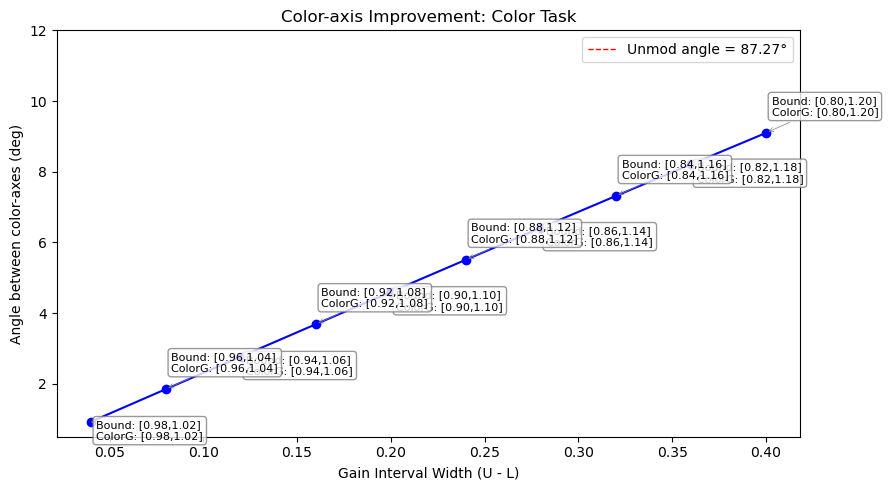

In [8]:

plt.figure(figsize=(9,5))
x_values = all_interval_widths

plt.plot(x_values, color_mod_improvement, marker='o', color='b')

all_annotations_simple = []

for old_anno in all_annotations:
    # 1) Split into lines (two lines: the first has " => ColorG:", the second has "ShapeG:")
    lines = old_anno.split("\n")

    # 2) Remove any line that starts with "ShapeG:"
    filtered_lines = [ln for ln in lines if not ln.startswith("ShapeG:")]
    # Now 'filtered_lines' should have only the first line,
    # e.g. "[0.80,1.20] => ColorG: [0.90,1.14]"

    if not filtered_lines:
        # If somehow everything got removed, skip
        all_annotations_simple.append("")
        continue

    first_line = filtered_lines[0]
    # first_line might look like: "[0.80,1.20] => ColorG: [0.90,1.14]"

    # 3) Parse out the portion before " => ColorG: " and after
    if " => ColorG: " in first_line:
        bounds_part, color_part = first_line.split(" => ColorG: ", maxsplit=1)
        # e.g. bounds_part = "[0.80,1.20]"
        #      color_part = "[0.90,1.14]"
        # We'll rebuild as two lines:
        new_anno = f"Bound: {bounds_part}\nColorG: {color_part}"
    else:
        # If no " => ColorG: " substring is found,
        # we'll just keep the entire line on one line:
        new_anno = first_line

    all_annotations_simple.append(new_anno)

# Now annotate
for i, (x, y, txt) in enumerate(zip(x_values, color_mod_improvement, all_annotations_simple)):
    dx = 0.003
    dy = 0.5 if (i % 2 == 0) else -0.5
    plt.annotate(
        txt,
        xy=(x, y),
        xytext=(x + dx, y + dy),
        textcoords="data",
        arrowprops=dict(arrowstyle="->", lw=0.5, color="gray"),
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )

# Reference line
plt.axhline(
    y=color_angle_unmod,
    color='r',
    linestyle='--',
    linewidth=1.0,
    label=f"Unmod angle = {color_angle_unmod:.2f}°"
)

plt.xlabel("Gain Interval Width (U - L)")
plt.ylabel("Angle between color-axes (deg)")
plt.title("Color-axis Improvement: Color Task")
plt.legend()
plt.grid(False)
plt.ylim(0.5,12)
plt.tight_layout()
plt.savefig("range_vs_degree_improvement_hard_pc2.png", dpi=150)
plt.show()


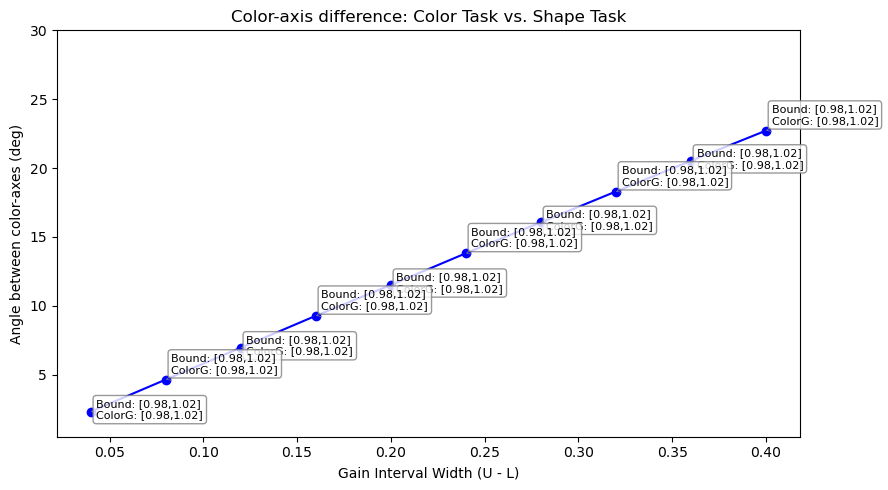

In [9]:
plt.figure(figsize=(9,5))
x_values = np.array(all_interval_widths)

plt.plot(x_values, angle_differences, marker='o', color='b')

all_annotations_complex = []

for old_anno in all_annotations:
    # 1) Change "Theory:" to "Bound:"
    updated = old_anno.replace("Theory:", "Bound:")

    all_annotations_complex.append(new_anno)


# We'll annotate each point with a small offset so they don't overlap too much
for i, (x, y, txt) in enumerate(zip(x_values, angle_differences, all_annotations_complex)):
        # slight shift in x and y for each data point
    dx = 0.003  # shift right
    dy = 0.5 if (i % 2 == 0) else -0.5  # alternate up/down
    plt.annotate(
            txt,
            xy=(x, y),
            xytext=(x + dx, y + dy),
            textcoords="data",
            arrowprops=dict(arrowstyle="->", lw=0.5, color="gray"),
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )

plt.xlabel("Gain Interval Width (U - L)")
plt.ylabel("Angle between color-axes (deg)")
plt.title("Color-axis difference: Color Task vs. Shape Task")
plt.grid(False)
plt.ylim(0.5,30)
plt.tight_layout()
plt.savefig("range_vs_degree_hard_pc2.png", dpi=150)
plt.show()

### Bigger Network